In [20]:
import numpy as np
from pathlib import Path
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, log_loss

from sklearn.gaussian_process.kernels import RBF, DotProduct, Matern, RationalQuadratic, WhiteKernel, ExpSineSquared
grid = dict()
grid['kernel'] = [1*RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2)), 
                  1*DotProduct(), 1*Matern(),  1*RationalQuadratic(),
                  1*Matern()+1*WhiteKernel(noise_level=0.5),
                  1*ExpSineSquared(),
                  1.0 * ExpSineSquared(length_scale=1.0, periodicity=3.0, length_scale_bounds=(0.1, 10.0), periodicity_bounds=(1.0, 10.0)),
                  1*Matern(length_scale=1.0, length_scale_bounds=(1e-1, 10.0), nu=1.5)+1*WhiteKernel(noise_level=0.5),
                ]


dataDir = Path.cwd().parent.parent.parent/'Data/processed'
ts_dataset = pd.read_csv(dataDir/"learner_118_new_meanTimeCost.csv", index_col="id")

In [21]:
ts_dataset

,Total_timeDelta_Seconds__sum_of_reoccurring_data_points,Total_timeDelta_Seconds__sum_of_reoccurring_values,"Total_timeDelta_Seconds__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""mean""","Total_timeDelta_Seconds__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""min""",Total_timeDelta_Seconds__autocorrelation__lag_9,Total_timeDelta_Seconds__sample_entropy,Total_timeDelta_Seconds__autocorrelation__lag_5,"Total_timeDelta_Seconds__fft_coefficient__attr_""real""__coeff_60","Total_timeDelta_Seconds__cwt_coefficients__coeff_13__w_2__widths_(2, 5, 10, 20)",milking_times__number_peaks__n_5,...,"Total_MilkProduction__cwt_coefficients__coeff_8__w_5__widths_(2, 5, 10, 20)",Total_timeDelta_Seconds__last_location_of_minimum,"DaysInMilk__linear_trend__attr_""slope""","milking_times__fft_coefficient__attr_""imag""__coeff_3",milking_times__number_peaks__n_1,BreedName_1,BreedName_2,BreedName_4,BreedName_99,label
id,,,,,,,,,,,,,,,,,,,,,
1,-0.148938,-0.137108,-0.599549,-0.037466,-0.858143,0.571451,-0.102382,-0.043234,0.697043,-0.673878,...,0.253646,0.650171,-0.224828,-1.208569,-0.032362,1.0,0.0,0.0,0.0,1
2,0.164452,0.181009,-0.423940,0.132696,0.290556,-1.856551,1.626652,-0.984812,-1.526357,-1.237833,...,-0.341874,-0.431548,-0.224552,0.208745,1.025141,0.0,1.0,0.0,0.0,0
3,0.765083,0.624520,-0.740572,0.073102,-0.591320,0.877939,0.168240,0.029852,0.398983,-1.237833,...,2.905989,0.907542,-0.192719,-1.336781,0.026388,1.0,0.0,0.0,0.0,1
4,-0.238420,-0.227939,-0.704557,-0.460532,-0.161239,-0.821921,0.429063,1.222054,0.490578,-1.237833,...,-0.011581,1.085493,0.021291,0.417031,-0.619864,0.0,0.0,1.0,0.0,0
5,-0.531245,-0.525181,1.574367,0.517369,0.237840,-1.208224,0.077915,0.536305,0.439460,-1.801787,...,-0.488084,-1.120431,0.518167,0.041955,-1.148616,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,-0.092416,-0.079734,2.300936,0.753258,-1.369126,-1.027787,0.164207,-0.024596,0.574318,-0.955855,...,-0.586410,-1.221363,0.371932,0.474052,-1.383617,0.0,1.0,0.0,0.0,1
115,-0.581501,-0.576195,0.706650,-0.003036,-1.223249,1.130458,-1.198307,-0.725614,1.201214,-0.391901,...,0.468305,1.219352,-0.224828,-0.423797,-0.443614,1.0,0.0,0.0,0.0,1
116,-0.218944,-0.208170,-0.005124,-0.394438,-0.364924,0.066710,-0.624508,-0.226075,1.307687,0.172054,...,1.211432,1.204985,-0.224828,-0.369839,0.790140,0.0,1.0,0.0,0.0,0


In [2]:
param_grid = {"alpha": [1e0, 1e-1, 1e-2, 1e-3],
              "kernel": [ExpSineSquared(l, p)
                         for l in np.logspace(-2, 2, 10)
                         for p in np.logspace(0, 2, 10)]}

In [22]:
X = ts_dataset.iloc[:, 0:len(ts_dataset.columns)-1].copy()
y = pd.DataFrame(ts_dataset.iloc[:, -1])
# split dataset into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=28)
model = GaussianProcessClassifier()
cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=5)
# exhausive search over different kernels
search = GridSearchCV(estimator=model, param_grid=grid, scoring='accuracy', cv=cv, n_jobs=-1)
# fit model into the dataset
result = search.fit(X, y)

print("Mean cross-validated score of the best_estimator: ", result.best_score_)
print("Best estimator parameters: ", result.best_params_)

means = result.cv_results_['mean_test_score']
params = result.cv_results_['params']
for mean, param in zip(means, params):
    print("Accuracy %.3f with: %r" % (mean, param))

d:\Toolbox\python\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
18 fits failed out of a total of 72.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1 fits failed with the following error:
Traceback (most recent call last):
  File "d:\Toolbox\python\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "d:\Toolbox\python\lib\site-packages\sklearn\gaussian_process\_gpc.py", line 715, in fit
    self.base_estimator_.fit(X, y)
  File "d:\Toolbox\python\lib\site-packages\sklearn\gaussian_process\_gpc.py", line 224, in fit
    self._constrained_optimization(
  File "d:\Toolbox\python\lib\site-packages\sklearn\gaussian_p

Mean cross-validated score of the best_estimator:  0.8782051282051282
Best estimator parameters:  {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}
Accuracy 0.813 with: {'kernel': 1**2 * RBF(length_scale=1)}
Accuracy 0.867 with: {'kernel': 1**2 * DotProduct(sigma_0=1)}
Accuracy 0.833 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}
Accuracy 0.856 with: {'kernel': 1**2 * RationalQuadratic(alpha=1, length_scale=1)}
Accuracy 0.723 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=1)}
Accuracy nan with: {'kernel': 1**2 * ExpSineSquared(length_scale=1, periodicity=3)}
Accuracy 0.878 with: {'kernel': 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)}


d:\Toolbox\python\lib\site-packages\sklearn\gaussian_process\kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__length_scale is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [12]:
y

,label
id,
1,1
2,0
3,1
4,0
5,0
...,...
114,1
115,1
116,0


In [23]:
y_test.value_counts()

label
0        13
1        11
dtype: int64

In [77]:
search.best_params_

{'kernel': 1**2 * Matern(length_scale=1, nu=1.5)}

In [25]:
#best_kernel = 1*DotProduct()
best_kernel = 1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5)

model_ini = GaussianProcessClassifier(kernel=best_kernel, random_state=10, n_jobs=-1, optimizer=None)
model_ini.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model_ini.score(X_train, y_train))

model_opt = GaussianProcessClassifier(kernel=best_kernel, random_state=18, n_jobs=-1)
model_opt.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model_opt.score(X_train, y_train))


print(
    "Log Marginal Likelihood: %.3f"
    % model_ini.log_marginal_likelihood(model_ini.kernel_.theta)
)
print(
    "Log Marginal Likelihood: %.3f"
    % model_opt.log_marginal_likelihood(model_opt.kernel_.theta)
)

print(
    "Log-loss: %.3f (initial) %.3f (optimized)"
    % (
        log_loss(y_train, model_ini.predict_proba(X_train)[:, 1]),
        log_loss(y_train, model_opt.predict_proba(X_train)[:, 1]),
    )
)

model_opt.predict_proba


Mean accuracy on training data:  1.0
Mean accuracy on training data:  1.0
Log Marginal Likelihood: -66.332
Log Marginal Likelihood: -36.872
Log-loss: 0.559 (initial) 0.189 (optimized)


<bound method GaussianProcessClassifier.predict_proba of GaussianProcessClassifier(kernel=1**2 * Matern(length_scale=1, nu=1.5) + 1**2 * WhiteKernel(noise_level=0.5),
                          n_jobs=-1, random_state=18)>

[Text(0.5, 1.0, 'GPC-DotProduct-Train'),
 Text(0.5, 0, 'Predicted probability(positive class)'),
 Text(0, 0.5, 'Count')]

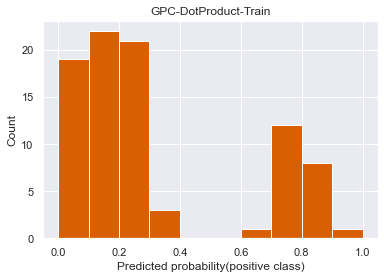

In [54]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
colors = plt.cm.get_cmap("Dark2")

fig = plt.figure()
ax = fig.add_subplot()

ax.hist(
    model_opt.predict_proba(X_train)[:,1],
    range=(0, 1),
    bins=10,
    label="GP",
    color=colors(1),
    )
ax.set(title="GPC-DotProduct-Train", xlabel="Predicted probability(positive class)", ylabel="Count")

In [55]:
y.value_counts()

label
0        11
1         6
dtype: int64

In [50]:
y_test.value_counts()

label
0        24
1         5
dtype: int64

In [18]:
model_opt.predict_proba(X_train)[:,0]

array([0.2106046 , 0.84047319, 0.85173971, 0.1444538 , 0.81162486,
       0.19780321, 0.25079181, 0.20313554, 0.95650529, 0.96846936,
       0.95593061, 0.92634373, 0.74389922, 0.74282412, 0.84529774,
       0.72905025, 0.8075667 , 0.73843693, 0.15658514, 0.21835854,
       0.95920903, 0.22004996, 0.95823759, 0.81617219, 0.7962108 ,
       0.93518495, 0.93215651, 0.30517105, 0.71734829, 0.85278873,
       0.93615969, 0.80153155, 0.80547532, 0.74231205, 0.69406327,
       0.09633175, 0.17948264, 0.82984861, 0.83789983, 0.92028683,
       0.93042304, 0.76940379, 0.24757791, 0.19201591, 0.75919633,
       0.19194801, 0.90401086, 0.92347138, 0.90456991, 0.75507705,
       0.78166977, 0.9528812 , 0.71305654, 0.84248292, 0.76890422,
       0.85726648, 0.88614933, 0.8242286 , 0.75170263, 0.75113801,
       0.75843072, 0.20602955, 0.81633134, 0.82935454, 0.92281863,
       0.74888475, 0.85055077, 0.93370087, 0.19511675, 0.88011106,
       0.72856978, 0.75051339, 0.72623344, 0.29068142, 0.91331

In [ ]:
pred_train = model.predict(X_train)

In [78]:
#best_kernel = 1*DotProduct()
#best_kernel = 1**2 * RationalQuadratic(alpha=1, length_scale=1)
#best_kernel = 1*RBF()
best_kernel = 1**2 * Matern(length_scale=1, nu=1.5)
model = GaussianProcessClassifier(kernel=best_kernel, random_state=20, n_jobs=-1)
model.fit(X_train, y_train.values.ravel())
print("Mean accuracy on training data: ", model.score(X_train, y_train))
print("Prediction on test data: ", model.predict(X_test))
pred_test = model.predict(X_test)
print("Prediction accuracy on test data: ", accuracy_score(y_test, pred_test))

Mean accuracy on training data:  0.7692307692307693
Prediction on test data:  [1 1 1 1]
Prediction accuracy on test data:  0.5


In [15]:
model.predict(X_train)

array([0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1],
      dtype=int64)

In [56]:
X

,Age__sum_values,Age__length,Age__standard_deviation,Age__variance,Total_MilkProduction__sum_values,Total_MilkProduction__length,Total_timeDelta_Seconds__root_mean_square,Total_timeDelta_Seconds__mean,Total_timeDelta_Seconds__standard_deviation,Total_timeDelta_Seconds__variance,...,milking_times__mean.1,milking_times__root_mean_square.1,milking_times__length.1,milking_times__maximum.1,milking_times__absolute_maximum.1,milking_times__median.1,milking_times__standard_deviation.1,milking_times__variance.1,BreedName_1,BreedName_2
id,,,,,,,,,,,,,,,,,,,,,
1,0.524434,1.085858,1.079378,1.101637,0.514914,1.085858,0.047985,-0.117160,0.251880,0.089892,...,1.007509,0.993223,-1.393442,-0.141421,-0.141421,-0.25,-0.402734,-0.443021,0.0,1.0
2,-0.008898,0.565870,0.470140,0.425319,1.514386,0.565870,0.292065,0.279305,0.312188,0.153706,...,2.806171,2.782333,-1.826475,1.060660,1.060660,4.00,-1.469615,-1.431467,0.0,1.0
3,-0.266430,-0.032117,-0.142078,-0.206394,0.080839,-0.032117,-1.373574,-1.252952,-1.441097,-1.215417,...,0.939348,0.956602,-1.281174,1.060660,1.060660,-0.25,0.528312,0.501252,1.0,0.0
4,-0.248974,0.123880,0.117640,0.055729,-0.001418,0.123880,0.716305,0.743236,0.666859,0.553087,...,0.148210,0.164350,0.130193,-0.141421,-0.141421,-0.25,0.539564,0.513130,1.0,0.0
5,1.342294,1.553847,1.710117,1.851932,1.268918,1.553847,-0.452687,-0.203410,-0.745908,-0.793001,...,-0.848795,-0.811337,0.402843,-1.343503,-1.343503,-0.25,0.941142,0.944306,1.0,0.0
6,-1.014733,-1.124092,-1.009327,-1.019051,0.006688,-1.124092,-1.703311,-1.455537,-1.927615,-1.416896,...,-0.686537,-0.644701,0.980221,-0.141421,-0.141421,-0.25,1.071787,1.087634,1.0,0.0
7,0.265372,0.617868,0.529172,0.488770,-1.340405,0.617868,-0.854216,-0.823393,-0.836862,-0.857266,...,-0.469579,-0.449131,-0.463223,-0.141421,-0.141421,-0.25,0.610262,0.588011,1.0,0.0
8,0.137415,0.565870,0.510070,0.468189,-0.916507,0.565870,1.163018,0.932482,1.401886,1.511931,...,1.057144,1.070814,-1.617978,1.060660,1.060660,-0.25,0.412278,0.379418,0.0,1.0
9,-0.777087,-0.812099,-0.787309,-0.820187,-1.244746,-0.812099,-0.493014,-0.482371,-0.466806,-0.578883,...,-0.343693,-0.365859,0.787762,-0.141421,-0.141421,-0.25,-0.452701,-0.491545,1.0,0.0


In [72]:
y.value_counts()

label
1        12
0         5
dtype: int64

In [70]:
pred_test

array([1, 1, 1, 1], dtype=int64)

In [71]:
y_test

,label
id,
8,0
4,1
2,1
12,0


In [23]:
prob_list = model.predict_proba(X_test)
prob_list

array([[0.84510538, 0.15489462],
       [0.21143657, 0.78856343],
       [0.49640214, 0.50359786],
       [0.89765126, 0.10234874],
       [0.66126536, 0.33873464],
       [0.93029955, 0.06970045],
       [0.58285054, 0.41714946],
       [0.81066071, 0.18933929],
       [0.74715522, 0.25284478],
       [0.55208842, 0.44791158],
       [0.81411315, 0.18588685],
       [0.89935271, 0.10064729],
       [0.18900759, 0.81099241],
       [0.94346549, 0.05653451],
       [0.60316412, 0.39683588],
       [0.86062169, 0.13937831],
       [0.51587677, 0.48412323],
       [0.7234912 , 0.2765088 ],
       [0.60559614, 0.39440386],
       [0.82852317, 0.17147683],
       [0.94054889, 0.05945111],
       [0.93733989, 0.06266011],
       [0.89697543, 0.10302457],
       [0.93164914, 0.06835086],
       [0.59767041, 0.40232959],
       [0.94466663, 0.05533337],
       [0.62988908, 0.37011092],
       [0.2784378 , 0.7215622 ],
       [0.79571289, 0.20428711]])

In [24]:
cow_id = X_test.index.copy()
cow_id = cow_id.astype(str)
cow_id

Index(['46', '95', '57', '85', '98', '42', '81', '108', '49', '3', '54', '53',
       '93', '44', '80', '2', '11', '36', '48', '27', '69', '82', '38', '20',
       '15', '40', '39', '64', '103'],
      dtype='object', name='id')

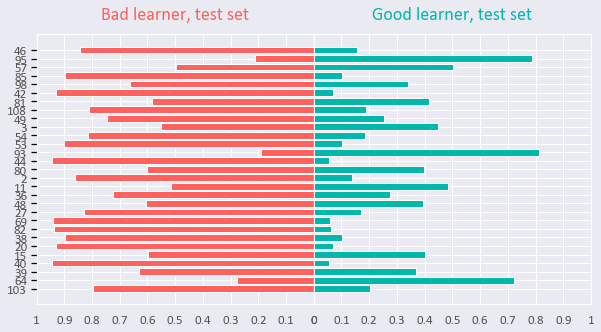

In [25]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import seaborn as sns
sns.set()

font_color = '#525252'
hfont = {'fontname':'Calibri'}
facecolor = '#eaeaf2'
color_red = '#fd625e'
color_blue = '#01b8aa'
index = cow_id
column0 = prob_list[:, 0]
column1 = prob_list[:, 1]
title0 = 'Bad learner, test set'
title1 = 'Good learner, test set'

fig, axes = plt.subplots(figsize=(10,5), facecolor=facecolor, ncols=2, sharey=True)
fig.tight_layout()

axes[0].barh(index, column0, align='center', color=color_red, zorder=10)
axes[0].set_title(title0, fontsize=18, pad=15, color=color_red, **hfont)
axes[1].barh(index, column1, align='center', color=color_blue, zorder=10)
axes[1].set_title(title1, fontsize=18, pad=15, color=color_blue, **hfont)

# If you have positive numbers and want to invert the x-axis of the left plot
axes[0].invert_xaxis() 

# To show data from highest to lowest
plt.gca().invert_yaxis()

axes[0].set(yticks=cow_id, yticklabels=cow_id)
axes[0].yaxis.tick_left()
axes[0].tick_params(axis='y', colors='black') # tick color

axes[0].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[0].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
axes[1].set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])

for label in (axes[0].get_xticklabels() + axes[0].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)
for label in (axes[1].get_xticklabels() + axes[1].get_yticklabels()):
    label.set(fontsize=13, color=font_color, **hfont)

plt.subplots_adjust(wspace=0, top=0.85, bottom=0.1, left=0.18, right=0.95)
filename = 'good&bad_learner'
plt.savefig(filename+'.png', facecolor=facecolor)

[Text(0.5, 1.0, 'GPC-Matern-Test'),
 Text(0.5, 0, 'Predicted probability(positive class)'),
 Text(0, 0.5, 'Count')]

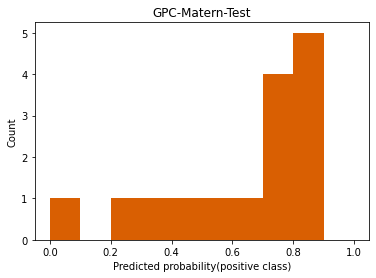

In [41]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
colors = plt.cm.get_cmap("Dark2")

fig = plt.figure()
ax = fig.add_subplot()

ax.hist(
    model.predict_proba(X_test)[:,1],
    range=(0, 1),
    bins=10,
    label="GP",
    color=colors(1),
    )
ax.set(title="GPC-Matern-Test", xlabel="Predicted probability(positive class)", ylabel="Count")

In [27]:
ts_dataset

,Total_timeDelta_Seconds__root_mean_square,Total_timeDelta_Seconds__mean,Total_timeDelta_Seconds__quantile__q_0.7,Total_timeDelta_Seconds__quantile__q_0.6,Total_timeDelta_Seconds__mean_abs_change,Total_timeDelta_Seconds__quantile__q_0.8,"Total_timeDelta_Seconds__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.0","Total_timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.8__ql_0.0","Total_timeDelta_Seconds__change_quantiles__f_agg_""var""__isabs_True__qh_0.6__ql_0.2",Total_timeDelta_Seconds__variance,...,milking_times__large_standard_deviation__r_0.2,Age__absolute_sum_of_changes,milking_times__number_peaks__n_3,"milking_times__agg_linear_trend__attr_""slope""__chunk_len_5__f_agg_""min""","DaysInMilk__fft_coefficient__attr_""real""__coeff_68",BreedName_1,BreedName_2,BreedName_4,BreedName_99,label
id,,,,,,,,,,,,,,,,,,,,,
1,-1.040361,-1.052863,-1.044957,-1.026876,-1.032387,-1.105493,-1.032387,-0.617057,-0.604327,-0.606794,...,0.855186,0.141238,-1.455100,0.638454,0.079254,0.0,0.0,1.0,0.0,0
2,2.671826,2.183100,1.493171,1.562288,2.132024,1.807215,2.132024,1.331007,2.399062,3.831282,...,0.855186,-1.538254,-1.455100,1.640353,0.079254,0.0,0.0,0.0,1.0,0
3,-0.343801,-0.478895,-0.609450,-0.648323,-0.377595,-0.563320,-0.377595,-0.520889,-0.494788,-0.318304,...,-1.169336,1.238049,-1.063017,-0.792830,0.079254,0.0,1.0,0.0,0.0,0
4,2.636363,3.097751,3.038055,2.773486,3.344164,3.524035,3.344164,4.127197,1.691970,1.799513,...,0.855186,-1.538254,-1.259059,0.638454,0.079254,0.0,0.0,0.0,1.0,0
5,-0.328595,-0.216554,-0.058725,-0.097482,-0.275922,-0.030931,-0.275922,-0.255325,-0.383424,-0.447120,...,-1.169336,-0.441443,-1.651141,0.352197,0.079254,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,-0.591009,-0.654956,-0.670955,-0.708766,-0.588152,-0.632789,-0.588152,-0.507241,-0.480969,-0.463305,...,-1.169336,1.203774,-0.278852,-0.300620,-0.560212,0.0,1.0,0.0,0.0,0
113,-0.938013,-0.998320,-1.044877,-1.035654,-0.932922,-1.005204,-0.932922,-0.607456,-0.580659,-0.575167,...,-1.169336,0.621093,0.897396,0.693267,-0.599109,1.0,0.0,0.0,0.0,1
114,-0.738820,-0.847421,-0.930653,-0.919554,-0.831356,-0.871078,-0.831356,-0.598774,-0.592489,-0.502985,...,0.855186,1.375150,0.309272,-1.219308,-0.747028,0.0,1.0,0.0,0.0,1


In [ ]:
mean_prediction, std_prediction = model.predict(X, return_std)

In [ ]:
plt.fill_between(
    X_train, y_train.values.ravel()
    pred
)